# SARSA Frozen Lake

In [138]:
# define path
RESULT_IMG_PATH = 'img/result_img_{}.png'

In [139]:
# import dependency
import gym # OpenAI Game Environment
import gym.envs.toy_text # Customized Map
import numpy as np
from tqdm import trange # Processing Bar
import matplotlib.pyplot as plt
%matplotlib inline

## Problem - Frozen Lake

[Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/)  est un environnement dans lequel un agent est capable de déplacer un personnage dans un monde en grille. En partant de l'état S, l'agent cherche à déplacer le personnage vers l'état cible G pour une récompense de 1. Bien que l'agent puisse choisir l'une des quatre actions possibles à chaque état (gauche, bas, droite, haut), il ne réussit que 13 fois en raison de l'état glissant F. L'agent est susceptible de se déplacer dans n'importe quelle autre direction les 23 fois restantes. De plus, si l'agent se trouve dans un état de trou H, l'agent a perdu et obtient une récompense  de 0.


+ S: Start State
+ G: Goal State
+ F: Frozen Surface
+ H: Hole State

![Frozen Lake](https://launchyourintelligentapphome.files.wordpress.com/2019/05/frozenlake_legended.png?w=531)

L'espace d'action est un espace discret de taille 4. C'est-à-dire qu'il a 4 valeurs distinctes (0, 1, 2 et 3). Les nombres correspondent à l'action suivante :
- 0 : gauche,
- 1 : bas,
- 2 : droite,
- 3 : haut. 


In [140]:
# initialization
env = gym.make('FrozenLake-v1') # avec transitions
# env = gym.make('FrozenLake-v1', is_slippery=False) # sans transitions

n_states, n_actions = env.observation_space.n, env.action_space.n
print('{} states'.format(n_states))
print('{} actions'.format(n_actions))
env.render()    

16 states
4 actions

SFFF
FHFH
FFFH
HFFG


In [141]:
# take a look
done = False
env.reset()
run = 0
while not done:
    # randomly pick an action
    action = np.random.randint(n_actions)
    # get feedback from the environment
    obvervation, reward, done, info = env.step(action)
    # show the environment
    env.render()
    run = run + 1
print(run)

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
3


### Probabilité de transitions
Le frozen lake est un environnement particulier ou votre agent a une probabilité de glisser à chaque action est de se retrouver dans un état qu'il ne souhaitait pas être à l'origine.
Uniquement pour vous donner une idée, voici ces probabilités (que votre modèle ne connait pas) : 
    

In [142]:
(env.env.P[0])

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

Ici, comme vous pouvez le deviner, les clés du dictionnaire 0,1,2,3 sont les actions que nous pouvons énoncer à partir de l'état 0. De plus, chaque action contient une liste, où chaque élément de la liste est un tuple indiquant la probabilité de transition vers l'état, l'état suivant, la récompense et si done=True done=False. (done=True si le prochain état est un Trou ou le But). Ainsi, env.P est une liste contenant tous les états où chaque état contient un dictionnaire qui met en correspondance toutes les actions possibles de cet état avec l'état suivant si nous prenons cette action, la probabilité d'entrer dans l'état suivant, la récompense et si le jeu se termine là ou non.

In [143]:
env.env.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

## Random Strategy

In [144]:
# experiment settings
n_episodes = 100
reward_array = np.zeros(n_episodes)

In [145]:
# performance of an agent taking random actions
t = trange(n_episodes)
# for each episode
for i in t:
    # reset environment
    env.reset()
    # done flag
    done = False
    while not done:
        # randomly pick an action
        action = np.random.randint(n_actions)
        # get feedback from the environment
        _, reward, done, _ = env.step(action)
        if done:
            # update processing bar
            t.set_description('Episode {} Reward {}'.format(i + 1, reward))
            t.refresh()
            reward_array[i] = reward
            reward_count = reward + reward
            break
env.close()

Episode 100 Reward 0.0: 100%|██████████| 100/100 [00:01<00:00, 64.28it/s]


In [146]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4) # compute the average of reward
print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.01


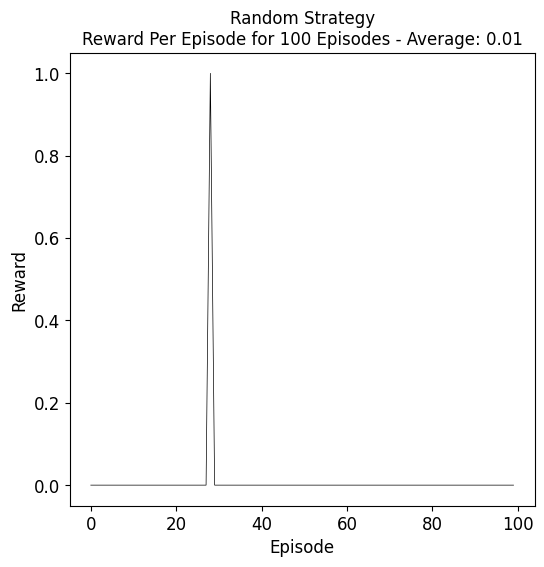

In [147]:
# show reward per episode
plt.subplots(figsize = (6, 6), dpi=100)
plt.plot(reward_array, color='black', linewidth=0.5)
plt.ylabel('Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Random Strategy\nReward Per Episode for {} Episodes - Average: {:.2f}'.format(n_episodes, avg_reward), 
          fontsize=12)
plt.savefig(RESULT_IMG_PATH.format(0), dpi=100, bbox_inches='tight')
plt.show()

## State Action Reward State Action (SARSA)

[State Action Reward State Action (SARSA)](https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action) 
est une méthode classique d'apprentissage d'une politique de processus de décision de Markov (MDP) pour résoudre des problèmes dans le domaine de l'apprentissage par renforcement. Comme l'indique le nom SARSA, il met à jour le $Q(s_{t}, a_{t})$, en fonction de l'état actuel $s_{t}$, de l'action choisie $a_{t}$, de la récompense $r_{t}$ due à cette action, du nouvel état $s_{t+1}$ après avoir pris cette action, et de l'action $a_{t+1}$ choisie pour ce nouvel état.
Étant donné cela, le tableau des valeurs Q peut être mis à jour par :

$$Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha[r_{t} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t})]$$

* $s$ est l'espace d'état
* $a$ est l'espace des actions 
* $P$ représente les probabilités de transition, $P(s,a,s')$ est la probabilité d'arriver à l'état $s'$ en effectuant l'action $a$ dans l'état $s$.
* $r$ est la fonction de récompense telle que $r(s,a,s')$ est la récompense obtenue en prenant l'action $a$ dans l'état $s$ et en arrivant à $s'$.
* $\gamma$ est le facteur d'actualisation


On peut voir dans la définition que la méthode SARSA vise à mettre à jour la politique par le biais d'interactions avec l'environnement, elle appartient donc à la famille des algorithmes d'apprentissage sur la politique.

À chaque instant $t$, SARSA conserve une estimation $\hat{Q}_t$ de la vraie fonction Q et utilise $\pi_{\hat{Q}_t}(a|s)$ pour choisir l'action $a_t$. Si $\tau \to 0$ avec un taux approprié comme $t \to \infty$, $\hat{Q}_t$ converge vers $Q$ et $\pi_{\hat{Q}_t}(a|s)$ converge vers la politique optimale $\pi^*$. 



La mise à jour SARSA au temps $t$ est effectuée comme suit :

1. Dans l'état $s_t$, prendre l'action $a_t \sim \pi_{\hat{Q}_t}(a|s_t)$ ;
2. Observer $s_{t+1}$ et récompenser $r_t$;
3. Sampler la prochaine action $a_{t+1} \sim \pi_{\hat{Q}_t}(a|s_{t+1})$;
4. Calculer $\delta_t = r_t + \gamma \hat{Q}_t(s_{t+1}, a_{t+1}) - \hat{Q}_t(s_t, a_t)$
5. Mettre à jour $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}$






### Training

In [148]:
# initialize the agent’s Q-table to zeros
def init_q(s, a):
    """
    s: number of states
    a: number of actions
    """
    return np.zeros((s, a))

# epsilon-greedy exploration strategy
def epsilon_greedy(Q, epsilon, n_actions, s):
    """
    Q: Q Table
    epsilon: exploration parameter
    n_actions: number of actions
    s: state
    """
    # selects a random action with probability epsilon
    if np.random.random() <= epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[s, :])
    
# SARSA Process
def sarsa(alpha, gamma, epsilon, n_episodes):
    """
    alpha: learning rate
    gamma: exploration parameter
    n_episodes: number of episodes
    """
    # initialize Q table
    Q = init_q(n_states, n_actions)
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)
    for i in t:
        # initial state
        s = env.reset()
        # initial action
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        done = False
        while not done:
            s_, reward, done, _ = env.step(a)
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            # update Q table
            Q[s, a] += alpha * (reward + (gamma * Q[s_, a_]) - Q[s, a])
            #insert formula #because on-policy ;)
            if done:
                t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                t.refresh()
                reward_array[i] = reward
                break
            s, a = s_, a_
    env.close()
    return Q, reward_array

In [149]:
# experiment settings
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon=0.5 # exploration parameter
n_episodes = 10000 # number of training episodes

In [150]:
# training
Q, reward_array = sarsa(alpha, gamma, epsilon, n_episodes)

Episode 10000 Reward 0.0: 100%|██████████| 10000/10000 [02:36<00:00, 64.10it/s]


In [151]:
# show Q table
Q

array([[0.0130761 , 0.01185842, 0.01177869, 0.01014269],
       [0.00656466, 0.00686812, 0.00738681, 0.01111202],
       [0.01784328, 0.01193133, 0.01268075, 0.01077331],
       [0.00828925, 0.00701583, 0.00568124, 0.0094812 ],
       [0.01461867, 0.01694788, 0.021596  , 0.00869737],
       [0.        , 0.        , 0.        , 0.        ],
       [0.03509133, 0.02338501, 0.02107746, 0.00354493],
       [0.        , 0.        , 0.        , 0.        ],
       [0.02124879, 0.03472687, 0.02586635, 0.03148841],
       [0.05371613, 0.09938992, 0.10706453, 0.05754343],
       [0.11420329, 0.20823514, 0.09104104, 0.02292087],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.11812822, 0.17454853, 0.22833845, 0.1791438 ],
       [0.21510886, 0.61165377, 0.43187737, 0.28384012],
       [0.        , 0.        , 0.        , 0.        ]])

### Visualisation de la policy obtenue

In [152]:
policy_estimation = []
for state in Q:
    policy_estimation.append(state.argmax())
    
def print_policy(policy):
    i = 0
    while i < 16:
        print(policy[i: i+4])
        i +=4
print_policy(policy_estimation) 
print("0:gauche, 1:bas, 2:droite,3:haut")

[0, 3, 0, 3]
[2, 0, 0, 0]
[1, 2, 1, 0]
[0, 2, 1, 0]
0:gauche, 1:bas, 2:droite,3:haut


In [153]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4)

print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.0479


### Testing

In [154]:
def eva(Q, n_episodes):
    """
    Q: trained Q table
    n_episodes: number of episodes
    """
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)
    for i in t:
        # initial state
        s = env.reset()
        # initial action
        a = np.argmax(Q[s])
        done = False
        while not done:
            s_, reward, done, _ = env.step(a)
            # pick an action according the state and trained Q table
            a_ = np.argmax(Q[s_])
            if done:
                t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                t.refresh()
                reward_array[i] = reward
                break
            s, a = s_, a_
    env.close()
    return reward_array

In [155]:
# experiment settings
n_episodes = 100 # number of testing episodes
reward_array = eva(Q, n_episodes)

Episode 100 Reward 0.0: 100%|██████████| 100/100 [00:01<00:00, 89.54it/s]


In [156]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4)
print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.08


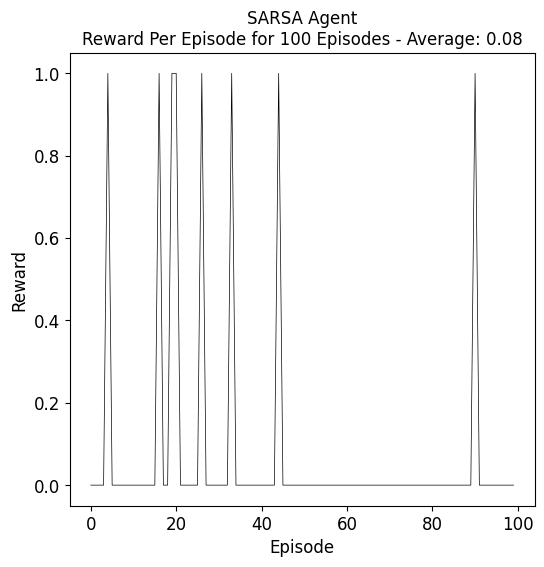

In [157]:
# show reward per episode
plt.subplots(figsize = (6, 6), dpi=100)
plt.plot(reward_array, color='black', linewidth=0.5)
plt.ylabel('Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('SARSA Agent\nReward Per Episode for {} Episodes - Average: {:.2f}'.format(n_episodes, avg_reward), 
          fontsize=12)
plt.savefig(RESULT_IMG_PATH.format(1), dpi=100, bbox_inches='tight')
plt.show()

In [159]:
# trained SARSA agent in Frozen Lake
done = False
s = env.reset()
env.render()
while not done:
    # pick an action
    a = np.argmax(Q[s])
    # get feedback from the environment
    s_, _, done, _ = env.step(a)
    # show the environment
    env.render()
    s = s_


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
